In [3]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# FrozenLake environment
I created this notebook to explore solutions to the OpenAI FrozenLake environment using Temporal Difference control methods, in the context of studying Reinforcement Learning. 

In __Frozen Lake__ an agent controls the movement of a character in a [4x4](https://gym.openai.com/envs/FrozenLake-v0/) or [8x8](https://gym.openai.com/envs/FrozenLake8x8-v0/) gridworld simulating a frozen lake. Some of the grids are walkable frozen surfaces (F) and others have holes (H). The Agent starts in S and must get to the goal position G.

If the agent reaches the __goal__, it receives a __reward of 1__. No rewards are given for any other actions.

This notebook can be used for both the 4x4 and 8x8 versions of FrozenLake.

We start by defining a function (*visualise_terrain*) for visualizing the terrain generated by a particular instantiation of the environment. We also create a dictionary which specifies action identities from their integer codes.

In [4]:
def visualise_terrain(envmap, shape=4, colormap='jet'):
    env_map = np.zeros((shape, shape), dtype=float)
    linear_map = [s for s in envmap if s in ['S', 'F', 'H', 'G']]
    number_map = np.zeros((shape**2))

    for s in range(len(linear_map)):
        if linear_map[s] == 'S':
            number_map[s] = 0.7
        elif linear_map[s] == 'G':
            number_map[s] = 1
        elif linear_map[s] == 'H':
            number_map[s] = 0
        else:
            number_map[s] = 0.3

    for r in range(shape):
        env_map[r,:] = number_map[shape*r:shape*r+shape]
    return env_map, colormap

actions = {}
actions[0] = 'L'
actions[1] = 'D'
actions[2] = 'R'
actions[3] = 'U'

## Agent
Next, we define our Agent. We provide it with attributes **nA** (number of actions available to it), **nS** (number of observables in this environment), **epsilon and epsilon decay rate**, **alpha** (how much to weight information from new episodes when updating) and **gamma** (how much to discount future rewards). We also bake in a **minimum value for epsilon**, to ensure it keeps a baseline level of explorative behaviour, in the long run.

We additionally define functions for selecting actions(**select_action**) and updating the agent's internal state (**agent_update**). The former uses an epsilon-greedy policy and the latter uses Q-learning as the method for updating the State-Action Value table Q.

In [137]:
class Agent:
    
    def __init__(self, nA, nS, epsilon=1, epsilon_decay = 0.5, min_epsilon = 0.001, alpha = 0.8,
                 alpha_decay = 0.99, gamma = 0.95, alpha_init = 0.8):
        self.nA = nA
        self.nS = nS
        self.Q = np.full((nS, nA), 0.01)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.alpha_init = alpha_init
        self.alpha = alpha_init
        self.gamma = gamma
        self.alpha_decay = alpha_decay
        
    def select_action(self, state):
        policy_p = ((np.ones(self.nA)*self.epsilon)/self.nA)
        greedy_Q = np.argmax(self.Q[state])
        policy_p[greedy_Q] = 1 - self.epsilon + (self.epsilon/self.nA)
        action = np.random.choice(self.nA, p=policy_p)
        return action
    
    def agent_update(self, state, action, reward, next_state, done):
        next_action = self.select_action(next_state)
        self.Q[state][action] = (1 - self.alpha) * self.Q[state][action] + self.alpha * (reward + self.gamma * np.max(self.Q[next_state]))
        
    def agent_update_MC(self, states, actions, rewards):
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            previous_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = previous_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - previous_Q)

In [143]:
def interact_MC(env, agent, num_episodes, window = 100, alpha_tune=False):
    windowed_rewards = []
    working_rewards = deque(maxlen=window)
    goals = 0
    
    for i_episode in range(1, num_episodes+1):
        ep_states, ep_actions, ep_rewards = [], [], []
        state = env.reset()
        agent.epsilon = max(agent.epsilon*agent.epsilon_decay, agent.min_epsilon)
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_states.append(state)
            ep_actions.append(action)
            ep_rewards.append(reward)
            state = next_state
            if done:
                agent.agent_update_MC(ep_states, ep_actions, ep_rewards)
                working_rewards.append(sum(ep_rewards))
                if sum(ep_rewards) >=1:
                    goals += 1
                    if alpha_tune:
                        agent.alpha = min(agent.alpha + 0.05*goals, 0.999)
                break
            
        if i_episode % window ==0:
            windowed_rewards.append(100*np.mean(working_rewards))
            print('Episode {}: goal reached in {} of last {} episodes'.format(i_episode, goals, window))
            goals = 0
            #agent.alpha = 0.1
            
        
    return windowed_rewards, agent.Q
            

## Agent-Environment Interaction
Lastly before we train our agent, we define an interaction function which structures the way our agent interacts with the environment and provides a readout of how well it's doing.

**interact** trains the agent for a number of episodes, keeps track of reward achieved per episode and whether the agent achieved the goal state or not, and averages rewards obtained over a window of (default) 100 episodes for assessment. During training, it prints the % of episodes over the last 100 in which the agent succeeded, and finally returns the average reward obtained over the defined window of episodes, as well as the Q-table.

In [87]:
def interact(env, agent, num_episodes, window = 100):
    windowed_rewards = []
    working_rewards = deque(maxlen=window)
    #actions = []
    goals = 0
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        episode_r = 0        
        
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.agent_update(state, action, reward, next_state, done)
            episode_r += reward
            state = next_state
            #actions.append(action)
            #print(action)
            #env.render()
            if done:
                working_rewards.append(episode_r)
                if episode_r ==1:
                    goals += 1
                break
        
        agent.epsilon = agent.min_epsilon + 0.99*np.exp(-agent.epsilon_decay*i_episode)
         
        if i_episode % window==0:
            windowed_rewards.append(100*np.mean(working_rewards))
            if i_episode % (window*10)==0:
                print('Episode {}: goal reached in {} of last {} episodes'.format(i_episode, goals, window*10))
                goals = 0
            
    return windowed_rewards, agent.Q

There is a small trick in the **interact** function code: if an episode terminates with reward, the agent decreases its alpha (learning rate). Therefore, over time, as the Q-table becomes a better and better estimate of the State-Value function, the agent will increasingly weight it over immediate experience, when updating its estimate of the State-Value function.


## Testing
Finally, we will instantiate our chosen environment, call **visualise_terrain** to render our terrain map, instantiate the agent and run the **interact** function to train it. 

We will start with the (ballpark-reasonable) default agent parameters and run for 5,000 episodes to make sure everything is running ok and the agent is learning something, then visualise its performance over time, in terms of the percentage of episodes terminating in success.

Episode 1000: goal reached in 230 of last 1000 episodes
Episode 2000: goal reached in 581 of last 1000 episodes
Episode 3000: goal reached in 632 of last 1000 episodes
Episode 4000: goal reached in 569 of last 1000 episodes
Episode 5000: goal reached in 593 of last 1000 episodes


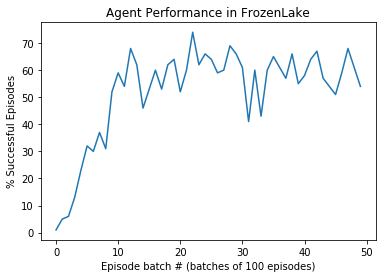

In [5]:
env = gym.make('FrozenLake-v0')
env_map, colormap = visualise_terrain(env.render(mode='ansi'), shape=int(math.sqrt(env.observation_space.n)))

agent = Agent(nA=env.action_space.n, nS=env.observation_space.n)
rewards, Q_table = interact(env, agent, num_episodes=5000)
plt.plot(range(len(rewards)), rewards)
plt.title('Agent Performance in FrozenLake');
plt.ylabel('% Successful Episodes');
plt.xlabel('Episode batch # (batches of 100 episodes)');

We now visualise its Q-table (left) where each row is a state and each column an action (**l**eft, **d**own, **r**ight, **u**p), value for each cell color-coded from dark blue (0) to deep red (1). To the right, we can see a map of the terrain the agent trained on (start = orange, goal = burgundy, frozen surface = light blue, hole = deep blue), and superimposed on each grid the most valuable action on it, according to the Q-table.

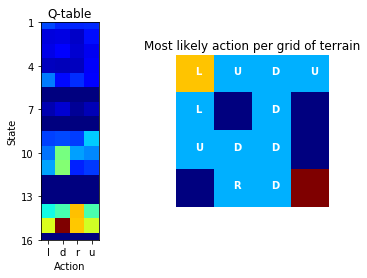

In [6]:
## Obtain most valuable actions per state and reshape into terrain conformation.
shape = int(math.sqrt(env.observation_space.n))
p_map = [actions[i] for i in np.argmax(Q_table, axis=1)]
p_map = np.reshape(np.array(p_map), (shape,shape))

## Generate subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
# Color-coded Q-table
ax1.imshow(Q_table, cmap='jet')#, vmin=0, vmax=1)
ax1.set_xticks(ticks=[0,1,2,3])
ax1.set_xticklabels(['l', 'd', 'r', 'u'])
ax1.set_yticks(np.arange(0,shape**2+1,3));
ax1.set_yticklabels(np.arange(1,shape**2+2,3));
ax1.set_ylabel('State')
ax1.set_xlabel('Action')
ax1.set_title('Q-table');
# Terrain-policy
ax2.imshow(env_map, vmin = 0, vmax = 1, cmap=colormap)
ax2.axis('off')
for r in range(shape):
    for c in range(shape):
        if env_map[c,r] not in [0.0, 1.0]:
            ax2.text(r,c, p_map[c,r], c='white', weight='bold')
ax2.set_title('Most likely action per grid of terrain');

## Developing & Improving
Not bad, but can we do better? Let's do some simple parameter exploration, trying out 3 different ranges of epsilon, minimum epsilon value, alpha and gamma. These parameters do interact with each other, so evidently parameter-wise iteration provides limited insight but i) I expect even this simplified approach can yield some improvement relative to the initial parameters & insight into agent performance in this task and ii) exploring the full parameter combinatorial space (I think 66 parameter combinations) would be very time consuming.

Let's run 5,000 episodes per exploration and explore 3 values for each of the 4 parameters. We will store the % successes over past 100 episodes and Q-table for each value/parameter and plot that for assessment.

In [7]:
num_eps_iter = 5000
####
eps_iter = [1, 0.1, 0.001]
rewards_eps = np.empty((num_eps_iter//100, len(eps_iter)))
Qtable_eps = np.empty((env.observation_space.n, env.action_space.n * len(eps_iter)))

print('Exploring epsilon range.')
env = gym.make('FrozenLake-v0')
for eps in eps_iter:
    agent = Agent(nA=env.action_space.n, nS=env.observation_space.n, epsilon=eps)
    i = eps_iter.index(eps)
    print('Iteration {}, epsilon value {}.'.format(i+1, eps))
    rewards_eps[:, i], Qtable_eps[:, i*env.action_space.n:i*env.action_space.n+env.action_space.n] = interact(env, agent, num_episodes=num_eps_iter)
print('Done!')
####
####
eps_min_iter = [0.01, 0.00000001, 0.0000000001]
rewards_epsmin = np.empty((num_eps_iter//100, len(eps_iter)))
Qtable_epsmin = np.empty((env.observation_space.n, env.action_space.n * len(eps_iter)))

print('Exploring epsilon min range.')
env = gym.make('FrozenLake-v0')
for eps in eps_min_iter:
    agent = Agent(nA=env.action_space.n, nS=env.observation_space.n, min_epsilon=eps)
    i = eps_min_iter.index(eps)
    print('Iteration {}, epsilon min value {}.'.format(i+1, eps))
    rewards_epsmin[:, i], Qtable_epsmin[:, i*env.action_space.n:i*env.action_space.n+env.action_space.n] = interact(env, agent, num_episodes=num_eps_iter)
print('Done!')
####
####
alpha_iter = [0.9, 0.8, 0.1]
rewards_alpha = np.empty((num_eps_iter//100, len(eps_iter)))
Qtable_alpha = np.empty((env.observation_space.n, env.action_space.n * len(eps_iter)))

print('Exploring alpha range.')
env = gym.make('FrozenLake-v0')
for alpha in alpha_iter:
    agent = Agent(nA=env.action_space.n, nS=env.observation_space.n, alpha=alpha)
    i = alpha_iter.index(alpha)
    print('Iteration {}, alpha value {}.'.format(i+1, alpha))
    rewards_alpha[:, i], Qtable_alpha[:, i*env.action_space.n:i*env.action_space.n+env.action_space.n] = interact(env, agent, num_episodes=num_eps_iter)
print('Done!')
####
####
gamma_iter = [0.9999, 0.995, 0.95]
rewards_gamma = np.empty((num_eps_iter//100, len(eps_iter)))
Qtable_gamma = np.empty((env.observation_space.n, env.action_space.n * len(eps_iter)))

print('Exploring gamma range.')
env = gym.make('FrozenLake-v0')
for gamma in gamma_iter:
    agent = Agent(nA=env.action_space.n, nS=env.observation_space.n, gamma=gamma)
    i = gamma_iter.index(gamma)
    print('Iteration {}, gamma value {}.'.format(i+1, gamma))
    rewards_gamma[:, i], Qtable_gamma[:, i*env.action_space.n:i*env.action_space.n+env.action_space.n] = interact(env, agent, num_episodes=num_eps_iter)
print('Done!')
######
######
print('Parameter exploration completed.')

Exploring epsilon range.
Iteration 1, epsilon value 1.
Episode 1000: goal reached in 260 of last 1000 episodes
Episode 2000: goal reached in 632 of last 1000 episodes
Episode 3000: goal reached in 628 of last 1000 episodes
Episode 4000: goal reached in 635 of last 1000 episodes
Episode 5000: goal reached in 574 of last 1000 episodes
Iteration 2, epsilon value 0.1.
Episode 1000: goal reached in 248 of last 1000 episodes
Episode 2000: goal reached in 586 of last 1000 episodes
Episode 3000: goal reached in 653 of last 1000 episodes
Episode 4000: goal reached in 631 of last 1000 episodes
Episode 5000: goal reached in 615 of last 1000 episodes
Iteration 3, epsilon value 0.001.
Episode 1000: goal reached in 275 of last 1000 episodes
Episode 2000: goal reached in 605 of last 1000 episodes
Episode 3000: goal reached in 631 of last 1000 episodes
Episode 4000: goal reached in 649 of last 1000 episodes
Episode 5000: goal reached in 679 of last 1000 episodes
Done!
Exploring epsilon min range.
Iter

Let's plot the results and think how we can improve performance.

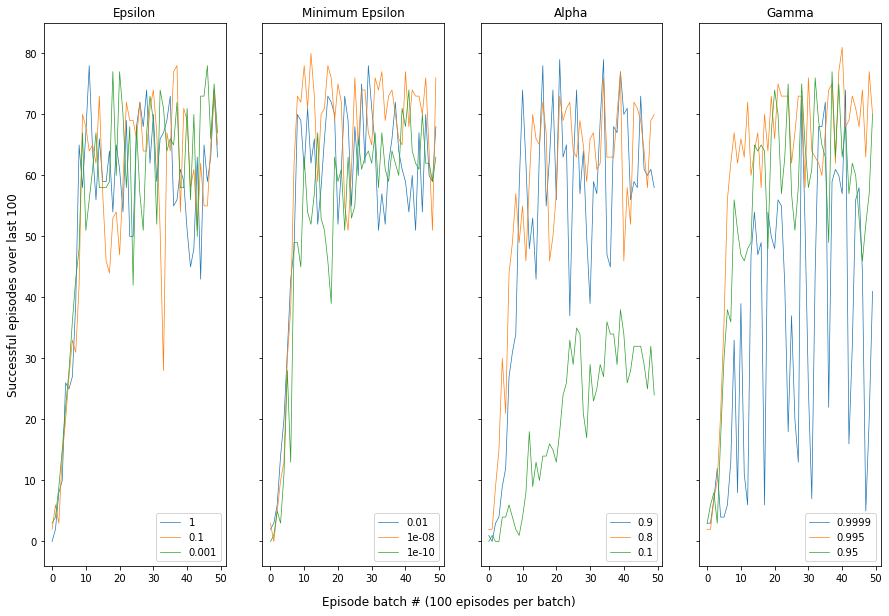

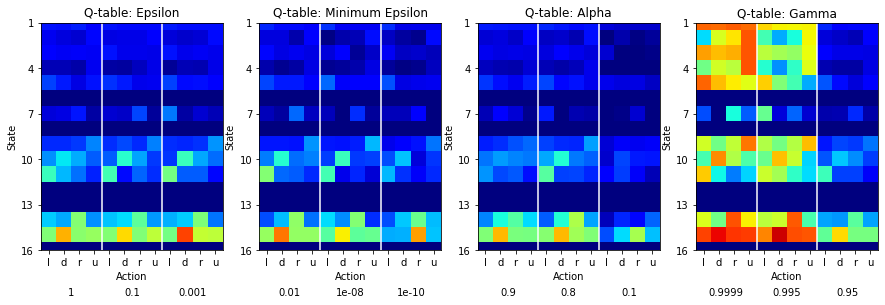

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,10))

for c in range(3):
    ax1.plot(rewards_eps[:,c], lw=0.7)
    ax1.set_title('Epsilon')
    ax1.legend(eps_iter,loc='lower right')
    ax1.set_ylabel('Successful episodes over last 100', fontsize=12)
    ax2.plot(rewards_epsmin[:,c], lw=0.7)
    ax2.set_title('Minimum Epsilon')
    ax2.legend(eps_min_iter ,loc='lower right')
    ax3.plot(rewards_alpha[:,c], lw=0.7)
    ax3.set_title('Alpha')
    ax3.legend(alpha_iter,loc='lower right')
    ax4.plot(rewards_gamma[:,c], lw=0.7)
    ax4.set_title('Gamma')
    ax4.legend(gamma_iter,loc='lower right')
fig.text(0.5, 0.07, 'Episode batch # (100 episodes per batch)', ha='center', fontsize=12);


#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(12,8))
fig, (axes) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(15,10))
axes = axes.ravel()

axes[0].imshow(Qtable_eps, cmap='jet', vmin=0.01, vmax=1)
axes[0].set_title('Q-table: Epsilon')
axes[1].imshow(Qtable_epsmin, cmap='jet', vmin=0.01, vmax=1)
axes[1].set_title('Q-table: Minimum Epsilon')
axes[2].imshow(Qtable_alpha, cmap='jet', vmin=0.01, vmax=1)
axes[2].set_title('Q-table: Alpha')
axes[3].imshow(Qtable_gamma, cmap='jet', vmin=0.01, vmax=1)
axes[3].set_title('Q-table: Gamma')

params = [eps_iter, eps_min_iter, alpha_iter, gamma_iter]

for a in range(4):
    axes[a].vlines(3.5, ymin=0, ymax=15, color='w')
    axes[a].vlines(7.5, ymin=0, ymax=15, color='w')
    axes[a].set_xticks(ticks=range(12))
    axes[a].set_xticklabels(['l', 'd', 'r', 'u']*3)
    axes[a].set_yticks(np.arange(0,shape**2+1,3));
    axes[a].set_yticklabels(np.arange(1,shape**2+2,3));
    axes[a].set_ylabel('State')
    axes[a].set_xlabel('Action')
    axes[a].text(1.5, 18, params[a][0], ha='center');
    axes[a].text(5.5, 18,  params[a][1], ha='center');
    axes[a].text(9.5, 18,  params[a][2], ha='center');

Let's now store the parameters that performed best in our exploration and train a new agent using them.

In [9]:
nA = env.action_space.n
nS = env.observation_space.n
good_epsilon = 0.001 
good_epsilon_min = 0.0000000001
good_alpha = 0.8
good_gamma = 0.995

agent = Agent(nA=nA, nS=nS, epsilon=good_epsilon, min_epsilon=good_epsilon_min, alpha=good_alpha, gamma=good_gamma)
rewards_improved, Q_table_improved = interact(env, agent, num_episodes=5000)

Episode 1000: goal reached in 317 of last 1000 episodes
Episode 2000: goal reached in 713 of last 1000 episodes
Episode 3000: goal reached in 761 of last 1000 episodes
Episode 4000: goal reached in 761 of last 1000 episodes
Episode 5000: goal reached in 734 of last 1000 episodes


### Does performance improve?

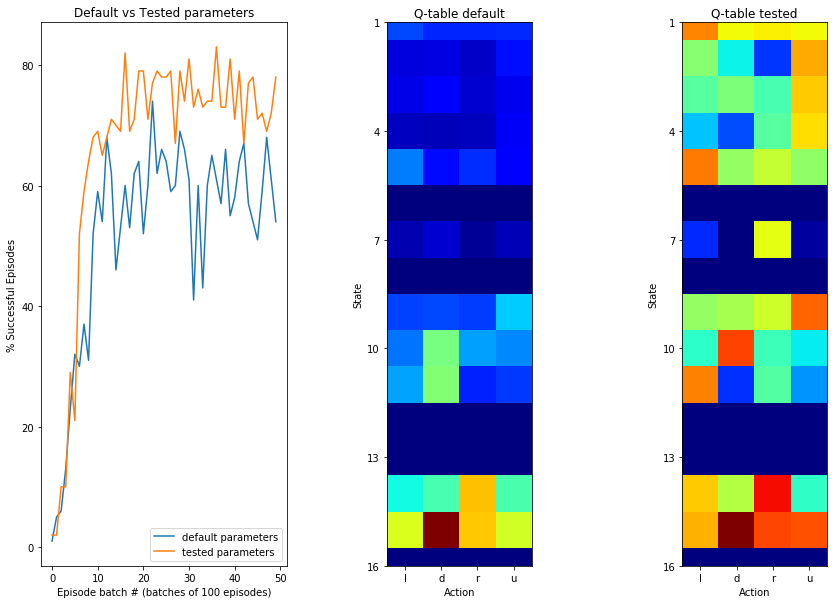

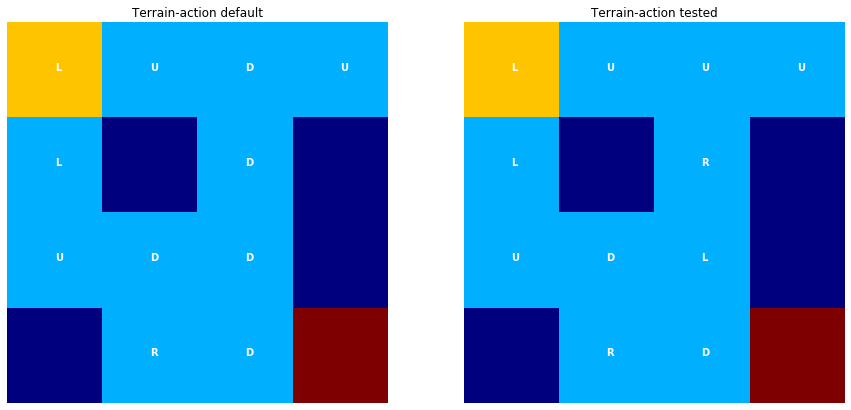

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15,10))

## Success episodes over training time default vs tested parameters
ax1.plot(range(len(rewards)), rewards, label='default parameters')
ax1.set_title('Default vs Tested parameters');
ax1.set_ylabel('% Successful Episodes');
ax1.set_xlabel('Episode batch # (batches of 100 episodes)');
ax1.plot(range(len(rewards_improved)), rewards_improved, label='tested parameters')
ax1.legend();

## Q-table default vs tested parameters
ax2.imshow(Q_table, cmap='jet')#, vmin=0, vmax=1)
ax2.set_xticks(ticks=[0,1,2,3])
ax2.set_xticklabels(['l', 'd', 'r', 'u'])
ax2.set_yticks(np.arange(0,shape**2+1,3));
ax2.set_yticklabels(np.arange(1,shape**2+2,3));
ax2.set_ylabel('State')
ax2.set_xlabel('Action')
ax2.set_title('Q-table default');

ax3.imshow(Q_table_improved, cmap='jet')#, vmin=0, vmax=1)
ax3.set_xticks(ticks=[0,1,2,3])
ax3.set_xticklabels(['l', 'd', 'r', 'u'])
ax3.set_yticks(np.arange(0,shape**2+1,3));
ax3.set_yticklabels(np.arange(1,shape**2+2,3));
ax3.set_ylabel('State')
ax3.set_xlabel('Action')
ax3.set_title('Q-table tested');


## Terrain-action maps with most valuable action for default vs tested parameters
p_map_improved = [actions[i] for i in np.argmax(Q_table_improved, axis=1)]
p_map_improved = np.reshape(np.array(p_map_improved), (shape,shape))

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,10))
ax1.imshow(env_map, vmin = 0, vmax = 1, cmap=colormap)
ax1.axis('off')
ax2.imshow(env_map, vmin = 0, vmax = 1, cmap=colormap)
ax2.axis('off')

for r in range(shape):
    for c in range(shape):
        if env_map[c,r] not in [0.0, 1.0]:
            ax1.text(r,c, p_map[c,r], c='white', weight='bold')
ax1.set_title('Terrain-action default');

for r in range(shape):
    for c in range(shape):
        if env_map[c,r] not in [0.0, 1.0]:
            ax2.text(r,c, p_map_improved[c,r], c='white', weight='bold')
ax2.set_title('Terrain-action tested');

A round of simple parameter exploration has improved performance considerable, in the range of 10-20% more sucessful episodes. Inspecting the terrain-action maps, we can see that the agent's policy only changed for the 3 top blocks of the 3rd column. 

# Some notes on interpretation
The greedy policy learnt by the agent can seem a bit odd, judging just from the terrain-action maps. But there's a couple points from the task environment that explain it. The documentation on FrozenLake isn't super detailed, so I've mainly inferred these points from agent behaviour & playing around with FrozenLake (I could be wrong in my assumptions), but its worth considering:

- There is no negative reward to incentivise the agent to exit the lake quickly & under Q-learning without this negative reward, every action taken in a state will increase Q(S,A) very slightly;
- There is no penalty for falling in a hole; 
- Taking an action that would bring the agent off-grid just keeps the agent in place;
- The environment is stochastic - for every action there is a probability p that the agent will 'slip' and move in a direction different from that intended.

Taken together, this means the agent is actually **encouraged** to meander along the terrain.

One puzzling aspect is the high value of action 'down' in State 15 (to the left of Goal). Due to environment stochasticity, I do expect every action at State 15 to have a high value, as there is a non-zero probability that an action that is 'not Right' will result in the Goal State. However, I expected that to mean all actions would have a high value, but action 'Right' would be the highest.

Closer inspection of 'default' and 'tested' parameter terrain maps suggests a possibility: **the agent learns to get stuck in a safe loop near the Goal state**. Recall the differences between the two maps are all in Column 3. And the result of these differences is that now, starting from State 11 (directly above Goal), there is a loop of actions that leads right into State 15 again:

- State 11 (L) --> State 10 (D) --> State 14 (R) --> State 15
- Recall the probability p that the agent slips and moves in a random different direction from intended. Once in State 15, the action 'Down' means the agent will either a) with probability p move into a loop entry point ('Up' into State 11 or 'Left' into State 14) or the Goal State; or b) with probability 1-p it will attempt 'Down', which is illegal, and stay in place safely, which doesn't terminate the episode.

If this is true, I would expect that **state-action pairs which maintain the loop should have higher values than usual**. Let us test this hypothesis below by comparing the Q(S,A) values for each of them relative to the remaining actions, with relative Q(S,A) values for 50,000 state-action pairs of drawn randomly from the Q-table for comparison.

In [11]:
# Define loop states, actions and their values relative to the other actions available in that state
loop_states = [11, 10, 14, 15]
loop_actions = [0, 1, 2, 1]
loop_rel_value = []
for s,a in zip(loop_states, loop_actions):
    loop_rel_value.append(Q_table_improved[s-1,a]/sum(Q_table_improved[s-1]) )

# Bootstrap by obtaining 50,000 relative values for random state-action pairs
i = 0
boot = []
while i <50000:
    for s,a in zip(random.sample(range(1,shape**2),1), random.sample(range(0,3),1)):
        #print('State {}, action {}: relative value {}'.format(s, actions[a], round(Q_table[s-1,a]/sum(Q_table[s-1,:]) ,2) ))
        boot.append( round(Q_table_improved[s-1,a]/sum(Q_table_improved[s-1,:]) ,2))
    i += 1
pcent_larger = [round(100*len(np.where(np.array(boot) <= t)[0])/50000,2) for t in loop_rel_value]
    
for s,a,v,p in zip(loop_states, loop_actions, loop_rel_value, pcent_larger):
    print('State {}, action {}: relative value {} is larger than {}% of 50,000 cases bootstrapped from Q-table.'\
          .format(s, actions[a], round(v ,2),p ))

State 11, action L: relative value 0.46 is larger than 95.61% of 50,000 cases bootstrapped from Q-table.
State 10, action D: relative value 0.41 is larger than 95.61% of 50,000 cases bootstrapped from Q-table.
State 14, action R: relative value 0.35 is larger than 91.43% of 50,000 cases bootstrapped from Q-table.
State 15, action D: relative value 0.3 is larger than 86.93% of 50,000 cases bootstrapped from Q-table.


The data above supports the loop hypothesis. **For the states contained in the loop, actions that maintain the agent in the loop are 'prefered' to their alternatives at a rate higher than preference rates between >90% of 50,000 randomly-drawn S-A pairs**.

Let's now train an agent with default parameters in a second environment which **is not slippery**, to confirm that the loop learnt by the agent is a consequence of environmental dynamics and not a mistake made in my programming or setting of weird combinations of parameters

In [12]:
env_slipless = gym.make('FrozenLake-v0', is_slippery=False)
agent = Agent(nA=nA, nS=nS)#, epsilon=good_epsilon, min_epsilon=good_epsilon_min, alpha=good_alpha, gamma=good_gamma)
rewards_slipless, Q_table_slipless = interact(env_slipless, agent, num_episodes=10000)

Episode 1000: goal reached in 644 of last 1000 episodes
Episode 2000: goal reached in 982 of last 1000 episodes
Episode 3000: goal reached in 988 of last 1000 episodes
Episode 4000: goal reached in 986 of last 1000 episodes
Episode 5000: goal reached in 989 of last 1000 episodes
Episode 6000: goal reached in 988 of last 1000 episodes
Episode 7000: goal reached in 990 of last 1000 episodes
Episode 8000: goal reached in 989 of last 1000 episodes
Episode 9000: goal reached in 987 of last 1000 episodes
Episode 10000: goal reached in 985 of last 1000 episodes


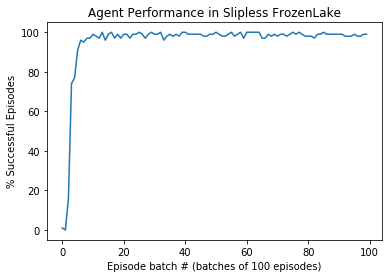

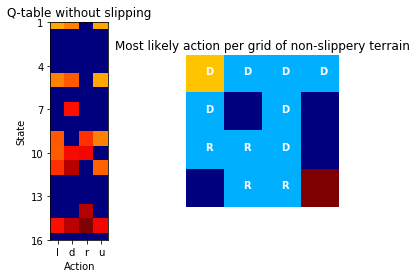

In [13]:
env_map_slipless, colormap = visualise_terrain(env_slipless.render(mode='ansi'), shape=int(math.sqrt(env_slipless.observation_space.n)))
shape = int(math.sqrt(env_slipless.observation_space.n))
p_map_slipless = [actions[i] for i in np.argmax(Q_table_slipless, axis=1)]
p_map_slipless = np.reshape(np.array(p_map_slipless), (shape,shape))


plt.plot(range(len(rewards_slipless)), rewards_slipless)
plt.title('Agent Performance in Slipless FrozenLake');
plt.ylabel('% Successful Episodes');
plt.xlabel('Episode batch # (batches of 100 episodes)');

## Generate subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
# Color-coded Q-table
ax1.imshow(Q_table_slipless, cmap='jet')#, vmin=0, vmax=1)
ax1.set_xticks(ticks=[0,1,2,3])
ax1.set_xticklabels(['l', 'd', 'r', 'u'])
ax1.set_yticks(np.arange(0,shape**2+1,3));
ax1.set_yticklabels(np.arange(1,shape**2+2,3));
ax1.set_ylabel('State')
ax1.set_xlabel('Action')
ax1.set_title('Q-table without slipping');
# Terrain-policy
ax2.imshow(env_map_slipless, vmin = 0, vmax = 1, cmap=colormap)
ax2.axis('off')
for r in range(shape):
    for c in range(shape):
        if env_map_slipless[c,r] not in [0.0, 1.0]:
            ax2.text(r,c, p_map_slipless[c,r], c='white', weight='bold')
ax2.set_title('Most likely action per grid of non-slippery terrain');

There is an important stochastic element to training since not all initiations will lead to the agent figuring out the task. When they do, it achieves near ~100% performance. We can now see that if we take away the slippery dynamic, the policy map resolves into the expected, containing no loops.

Episode 100: goal reached in 0 of last 100 episodes
Episode 200: goal reached in 2 of last 100 episodes
Episode 300: goal reached in 2 of last 100 episodes
Episode 400: goal reached in 2 of last 100 episodes
Episode 500: goal reached in 4 of last 100 episodes
Episode 600: goal reached in 0 of last 100 episodes
Episode 700: goal reached in 4 of last 100 episodes
Episode 800: goal reached in 10 of last 100 episodes
Episode 900: goal reached in 5 of last 100 episodes
Episode 1000: goal reached in 5 of last 100 episodes
Episode 1100: goal reached in 3 of last 100 episodes
Episode 1200: goal reached in 31 of last 100 episodes
Episode 1300: goal reached in 16 of last 100 episodes
Episode 1400: goal reached in 12 of last 100 episodes
Episode 1500: goal reached in 11 of last 100 episodes
Episode 1600: goal reached in 6 of last 100 episodes
Episode 1700: goal reached in 11 of last 100 episodes
Episode 1800: goal reached in 9 of last 100 episodes
Episode 1900: goal reached in 6 of last 100 episo

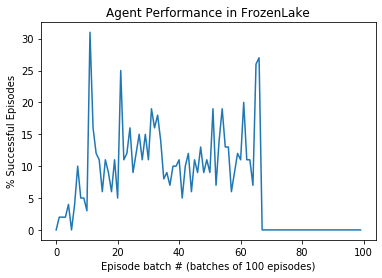

In [149]:
env = gym.make('FrozenLake-v0', is_slippery=True)

nA = env.action_space.n
nS = env.observation_space.n
MC_epsilon = 1
MC_epsilon_min = 0.001
MC_alpha = 0.01
MC_gamma = 1
MC_epsilon_d = 0.9

env_map_MC, colormap = visualise_terrain(env.render(mode='ansi'), shape=int(math.sqrt(env.observation_space.n)))

agent = Agent(nA=nA, nS=nS, epsilon=MC_epsilon,
              min_epsilon=MC_epsilon_min, alpha_init=MC_alpha,
              gamma=MC_gamma, epsilon_decay=MC_epsilon_d)
rewards_MC, Q_table_MC = interact_MC(env, agent, num_episodes=10000, window=100, alpha_tune=True)

plt.plot(range(len(rewards_MC)), rewards_MC)
plt.title('Agent Performance in FrozenLake');
plt.ylabel('% Successful Episodes');
plt.xlabel('Episode batch # (batches of 100 episodes)');

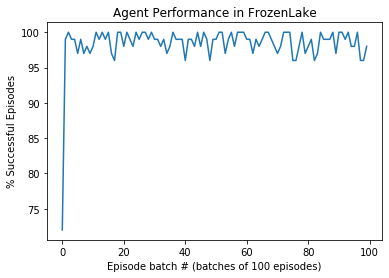

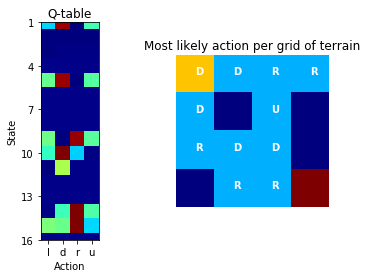

In [106]:


## Obtain most valuable actions per state and reshape into terrain conformation.
shape = int(math.sqrt(env.observation_space.n))
p_map = [actions[i] for i in np.argmax(Q_table_MC, axis=1)]
p_map = np.reshape(np.array(p_map), (shape,shape))

## Generate subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
# Color-coded Q-table
ax1.imshow(Q_table_MC, cmap='jet')#, vmin=0, vmax=1)
ax1.set_xticks(ticks=[0,1,2,3])
ax1.set_xticklabels(['l', 'd', 'r', 'u'])
ax1.set_yticks(np.arange(0,shape**2+1,3));
ax1.set_yticklabels(np.arange(1,shape**2+2,3));
ax1.set_ylabel('State')
ax1.set_xlabel('Action')
ax1.set_title('Q-table');
# Terrain-policy
ax2.imshow(env_map_MC, vmin = 0, vmax = 1, cmap=colormap)
ax2.axis('off')
for r in range(shape):
    for c in range(shape):
        if env_map_MC[c,r] not in [0.0, 1.0]:
            ax2.text(r,c, p_map[c,r], c='white', weight='bold')
ax2.set_title('Most likely action per grid of terrain');